In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import scipy
from scipy.stats import pearsonr
import os

# Read sequence run ID

In [3]:
df_run = pd.read_csv('qiime2_output/SraRunTable.txt')
df_run = df_run[['Run','Submitter_Id']]
df_run.head()

,Run,Submitter_Id
0,ERR2287717,sample_10.as.01
1,ERR2287733,sample_10.as.05
2,ERR2287735,sample_10.as.12
3,ERR2287741,sample_10.as.24
4,ERR2287742,sample_10.as.25


# Read qPCR

In [4]:
df_qpcr = pd.read_excel('16s_copies.xlsx')
df_qpcr.columns = ['Mouse','Day','qPCR']
df_qpcr.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Mouse,Day,qPCR
0,78_0,-9,1.274399e+12
1,78_1,-9,2.178588e+12
2,78_10,-9,3.700869e+12
3,78_3,-9,5.845707e+11
4,78_30,-9,1.900437e+12


# Create metadata

In [5]:
df_meta = pd.read_excel('metadata.xlsx')
df_meta.columns = ['Submitter_Id','Mouse','Day']
df_meta['Treatment'] = [x.split('_')[3] for x in df_meta.Submitter_Id]
df_meta['Submitter_Id'] = [('.').join(x.split('_')[0:3]).replace('X10','sample_10') for x in df_meta.Submitter_Id]
df_meta.head()

,Submitter_Id,Mouse,Day,Treatment
0,sample_10.as.40,78_0,-6,Ctrl
1,sample_10.as.42,78_3,-6,Ctrl
2,sample_10.as.43,78_10,-6,Ctrl
3,sample_10.as.44,78_30,-6,Ctrl
4,sample_10.as.50,80_0,-6,Streptomycin


In [6]:
set(df_meta.Day)

{-9, -6, 0, 14}

In [7]:
set(df_meta.Treatment)

{'Ampicillin',
 'Aztreonam',
 'Ctrl',
 'Metronidazole',
 'Streptomycin',
 'Vancomycin'}

In [8]:
# Metronidazole data is lost due to the lack of sequencing data
df_meta = pd.merge(df_meta, df_run, left_on=['Submitter_Id'], right_on=['Submitter_Id'], how='inner')
df_meta = pd.merge(df_meta, df_qpcr, left_on=['Mouse','Day'], right_on=['Mouse','Day'], how='inner').set_index('Run')
df_meta.head()

,Submitter_Id,Mouse,Day,Treatment,qPCR
Run,,,,,
ERR2300233,sample_10.as.40,78_0,-6,Ctrl,3.451182e+12
ERR2300234,sample_10.as.42,78_3,-6,Ctrl,2.067736e+12
ERR2300235,sample_10.as.43,78_10,-6,Ctrl,1.595937e+12
ERR2300236,sample_10.as.44,78_30,-6,Ctrl,2.635397e+12
ERR2300237,sample_10.as.50,80_0,-6,Streptomycin,1.901856e+12


In [9]:
set(df_meta.Treatment)

{'Ampicillin', 'Aztreonam', 'Ctrl', 'Streptomycin', 'Vancomycin'}

# Read taxonomy data

In [10]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,86b3e88a9f2a337c2424c2731093711b,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999992,g__Lactobacillus
1,4ee1d23701d650a2b118cff2343b466f,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.924880,s__Lactobacillus_hominis
2,f3ba3146cedb161b057a1e17168a504b,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997593,g__Blautia
5,2e2650b29d5b2a22aa30b7524b851e75,d__Bacteria; p__Verrucomicrobiota; c__Verrucom...,0.805402,s__Akkermansia_muciniphila
7,96568c623f9a56fefbc481e79dfe00c8,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.983496,g__Enterococcus


In [11]:
df_tax.Confidence.min()

0.8001064878760142

# Read count data

In [12]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", skiprows=[0], index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
df_count = df_count.loc[df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum seq depth = %d" % (df_count.sum(axis=1).min()))
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum seq depth = 1438


#OTU ID,86b3e88a9f2a337c2424c2731093711b,4ee1d23701d650a2b118cff2343b466f,f3ba3146cedb161b057a1e17168a504b,2e2650b29d5b2a22aa30b7524b851e75,96568c623f9a56fefbc481e79dfe00c8,73655ea865c6d1fefe2050573e82733e,e460ab6d5ad329efae8109974d86e49a,72d644f8c57a0b6bb2964dc2758978b8,cb2a93b551f84770db1a193e68bc3cb3,bb9f29686b0cf27d85ee681909abee23,...,e325b498a85b0b4f4648fb91856503d7,1fafc70e49d00885bb58accec54ed2d8,b2228a93b091958e5f77fb376b4784cb,80ab2e2dced8380e2235b807a014547b,9659c1021d2e623476e97cd6366032c8,cde5e28350e1b3b47eb9b7c0544b352b,2a591700d2d4c7cfcd485a6e052f225b,a64fb45afb418d17442bb8d5013e13f0,bf3dc4756e4a6d1307c3a805cb8c116d,2c011e7303fbcd21ad6c215ae7e55a93
ERR2287717,0.277402,0.266431,0.0,0.000000,0.000382,0.0,0.014023,0.123724,0.008967,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2287730,0.161499,0.183387,0.0,0.000000,0.000702,0.0,0.042514,0.094149,0.068472,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2287731,0.204298,0.176332,0.0,0.000000,0.000343,0.0,0.016428,0.122158,0.015570,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2287732,0.181240,0.213037,0.0,0.000596,0.000000,0.0,0.024841,0.100954,0.060016,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2287733,0.237208,0.219501,0.0,0.000000,0.000069,0.0,0.021043,0.093619,0.017401,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot dynamics of oral and gut bacteria

In [13]:
df_blast_100 = pd.read_csv("qiime2_output/asv-sequences/blast_fMOMD/blast_fMOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_meta_oral = pd.merge(df_meta, df_relabun[list(set(df_blast_100.query_accver).intersection(df_relabun.columns))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1), left_index=True, right_index=True)
df_meta_oral['qPCR_oral'] = df_meta_oral['qPCR']*df_meta_oral['OralFrac']
df_meta_oral['qPCR_gut'] = df_meta_oral['qPCR']*(1-df_meta_oral['OralFrac'])
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral.OralFrac)
df_meta_oral['log10_qPCR'] = np.log10(df_meta_oral.qPCR)
df_meta_oral['Color'] = sns.color_palette("tab10").as_hex()[8]
for k,abx in enumerate(['Ctrl','Ampicillin','Aztreonam','Streptomycin','Vancomycin']):
    df_meta_oral.loc[df_meta_oral.Treatment == abx, 'Color'] = sns.color_palette("tab10").as_hex()[k]
df_meta_oral = df_meta_oral.sort_values(['Mouse','Day'])
df_meta_oral.Day = df_meta_oral.Day.astype(str)

# add alpha diversity
shannon = []
for sid in df_meta_oral.index:
    shannon.append(-np.sum([x*np.log(x) for x in np.array(df_relabun.loc[sid]) if x>0]))
df_meta_oral['Shannon'] = shannon
    
df_meta_oral.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Submitter_Id,Mouse,Day,Treatment,qPCR,OralFrac,qPCR_oral,qPCR_gut,log10_OralFrac,log10_qPCR,Color,Shannon
ERR2287717,sample_10.as.01,78_0,-9,Ctrl,1.274399e+12,0.000668,8.509770e+08,1.273548e+12,-3.175388,12.105305,#1f77b4,2.511781
ERR2300233,sample_10.as.40,78_0,-6,Ctrl,3.451182e+12,0.000374,1.291707e+09,3.449890e+12,-3.426804,12.537968,#1f77b4,4.245947
ERR2300248,sample_10.as.79,78_0,0,Ctrl,2.790903e+11,0.000155,4.339259e+07,2.790469e+11,-3.808329,11.445745,#1f77b4,3.719517
ERR2300267,sample_10.as.118,78_0,14,Ctrl,2.677723e+12,0.001166,3.121799e+09,2.674601e+12,-2.933361,12.427766,#1f77b4,1.477988
ERR2287730,sample_10.as.02,78_1,-9,Ctrl,2.178588e+12,0.000561,1.222724e+09,2.177365e+12,-3.250847,12.338175,#1f77b4,3.066095


In [14]:
for tr in set(df_meta_oral.Treatment):
    print("# %s mice = %d" % (tr, len(set(df_meta_oral[df_meta_oral.Treatment==tr].Mouse))))
    print("# %s samples = %d" % (tr, len(set(df_meta_oral[df_meta_oral.Treatment==tr].Submitter_Id))))

# Streptomycin mice = 5
# Streptomycin samples = 14
# Aztreonam mice = 5
# Aztreonam samples = 16
# Vancomycin mice = 5
# Vancomycin samples = 20
# Ctrl mice = 5
# Ctrl samples = 15
# Ampicillin mice = 4
# Ampicillin samples = 8


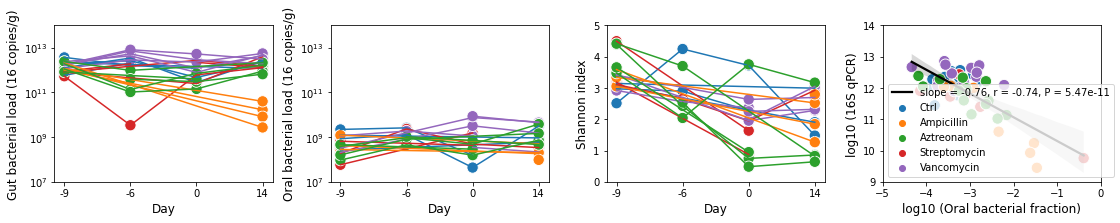

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

# dynamics of gut bacteria
hue_order_color = df_meta_oral[['Mouse','Color']].drop_duplicates()
_ = sns.lineplot(x="Day", y="qPCR_gut", hue="Mouse", data=df_meta_oral, ax=ax[0], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color))
_ = sns.scatterplot(x="Day", y="qPCR_gut", hue="Mouse", data=df_meta_oral, ax=ax[0], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color), s=128)
_ = ax[0].set_xlabel('Day', fontsize=12)
_ = ax[0].set_ylabel('Gut bacterial load (16 copies/g)', fontsize=12)
_ = ax[0].legend().remove()
_ = ax[0].set_yscale('log')
_ = ax[0].set_ylim([1e7,1e14])

# dynamics of oral bacteria
hue_order_color = df_meta_oral[['Mouse','Color']].drop_duplicates()
_ = sns.lineplot(x="Day", y="qPCR_oral", hue="Mouse", data=df_meta_oral[df_meta_oral.OralFrac>0], ax=ax[1], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color))
_ = sns.scatterplot(x="Day", y="qPCR_oral", hue="Mouse", data=df_meta_oral[df_meta_oral.OralFrac>0], ax=ax[1], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color), s=128)
_ = ax[1].set_xlabel('Day', fontsize=12)
_ = ax[1].set_ylabel('Oral bacterial load (16 copies/g)', fontsize=12)
_ = ax[1].legend().remove()
_ = ax[1].set_yscale('log')
_ = ax[1].set_ylim([1e7,1e14])

# dynamics of alpha diversity
hue_order_color = df_meta_oral[['Mouse','Color']].drop_duplicates()
_ = sns.lineplot(x="Day", y="Shannon", hue="Mouse", data=df_meta_oral[df_meta_oral.OralFrac>0], ax=ax[2], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color))
_ = sns.scatterplot(x="Day", y="Shannon", hue="Mouse", data=df_meta_oral[df_meta_oral.OralFrac>0], ax=ax[2], hue_order=list(hue_order_color.Mouse), palette=list(hue_order_color.Color), s=128)
_ = ax[2].set_xlabel('Day', fontsize=12)
_ = ax[2].set_ylabel('Shannon index', fontsize=12)
_ = ax[2].legend().remove()
_ = ax[2].set_ylim([0,5])

# oral fraction vs qPCR
_ = sns.scatterplot(x="log10_OralFrac", y="log10_qPCR", hue='Treatment', data=df_meta_oral[df_meta_oral.OralFrac>0],
                    ax=ax[3], s=128, palette=sns.color_palette("tab10").as_hex()[0:5], hue_order=['Ctrl','Ampicillin','Aztreonam','Streptomycin','Vancomycin'])
fit = scipy.stats.linregress(x=df_meta_oral[df_meta_oral.OralFrac>0].log10_OralFrac, y=df_meta_oral[df_meta_oral.OralFrac>0].log10_qPCR)
corr = pearsonr(x=df_meta_oral[df_meta_oral.OralFrac>0].log10_OralFrac, y=df_meta_oral[df_meta_oral.OralFrac>0].log10_qPCR)
_ = sns.regplot(x="log10_OralFrac", y="log10_qPCR", data=df_meta_oral[df_meta_oral.OralFrac>0], ax=ax[3], color='k', 
                scatter=False, label='slope = %2.2f, r = %2.2f, P = %2.2e' % (fit.slope, corr[0], corr[1]))
_ = ax[3].legend()
_ = ax[3].set_xlabel('log10 (Oral bacterial fraction)', fontsize=12)
_ = ax[3].set_ylabel('log10 (16S qPCR)', fontsize=12)
_ = ax[3].set_xlim([-5,0])
_ = ax[3].set_ylim([9,14])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Staffas_2018CHM.svg", dpi=600, bbox_inches='tight')

## What dominates the 3 ampicillin-treated samples and 1 streptomycin-treated samples that have very low qPCR?

In [15]:
samples2study = list(df_meta_oral[df_meta_oral.OralFrac>0.01].index)
selected_df_relabun = df_relabun.loc[samples2study, list(set(df_blast_100.query_accver).intersection(df_relabun.columns))]
selected_df_relabun = selected_df_relabun.loc[:, (selected_df_relabun != 0).any(axis=0)]
selected_df_relabun_tax = pd.merge(
    selected_df_relabun.T.mean(axis=1).to_frame().rename({0:'MeanRelab'}, axis=1),
    df_tax.set_index('ASV'),
    left_index=True,
    right_index=True,
    how='inner')
selected_df_relabun_tax.sort_values('MeanRelab', ascending=False)

,MeanRelab,Taxon,Confidence,LowestTaxonomy
a209a2c6a19ff6ec5e2592b702e0a617,0.113993,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999994,g__Streptococcus
045f970aba762f44c5047b0276c7cab6,0.005679,d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...,0.993805,g__Staphylococcus
f43a74f5d142f240da8b0ac9c0fe85d7,0.003086,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999956,g__Lactobacillus
9a1a2e61d06e167a329c9537e2b68f9d,0.000167,d__Bacteria; p__Actinobacteriota; c__Actinobac...,0.989311,g__Sanguibacter
74b2f6fd747b92614172cda2ef18f80e,0.000049,d__Bacteria; p__Firmicutes; c__Bacilli; o__Sta...,0.889617,g__Staphylococcus
f52837158a3b3b7e4de0236b88025956,0.000030,d__Bacteria; p__Campilobacterota; c__Campyloba...,1.000000,g__Helicobacter
ddc42630f2db518d727491d67d2e7b46,0.000021,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999995,g__Aerococcus


In [ ]:
# a209a2c6a19ff6ec5e2592b702e0a617 is a streptococcus thermophilus, or streptococcus salivarius, or streptococcus vestibularis (via blast)